In [1]:
suppressMessages(library("rwwa"))

In [3]:
gmst <- read.table("gmst.txt", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2025]
cov_2025 <- data.frame(gmst = 0)
cov_pi <- data.frame(gmst = c("pi" = -1.3, "2000" = -0.66))

# Loop over all files & fit GEV to both

In [7]:
fl <- list.files("/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/UK_heat", pattern = "tx3x_.+csv", full.names = T)
for(fnm in fl) {
    if (file.exists(paste0("res/res_", strsplit(fnm, "/")[[1]][10]))) next
    
    varnm <- strsplit(strsplit(fnm, "/")[[1]][10], "_")[[1]][1]
    rp_est <- switch(varnm, "tx1x" = 25, "tx3x" = 5, "tx1x-jja" = 25, "tx3x-jja" = 5)
    
    df <- merge(gmst, read.csv(fnm, col.names = c("year", "tx")))
    df <- df[!is.na(df$tx),]
    
    mdl <- fit_ns("gev", "shift", df, varnm = "tx", covnm = "gmst", lower = F)
    exp_ev <- eff_return_level(mdl, rp = rp_est, fixed_cov = cov_2025)
    mdl <- fit_ns("gev", "shift", df, varnm = "tx", covnm = "gmst", lower = F, ev = exp_ev, ev_year = 2025)
    
    res <- boot_ci(mdl, cov_f = cov_2025, cov_cf = cov_pi, rp = rp_est)
    write.csv(res, paste0("res/res_", strsplit(fnm, "/")[[1]][10]))
    
    png(paste0("fig/",gsub("csv", "png", strsplit(fnm, "/")[[1]][10])), height = 360, width = 360*3); {
        prep_window(c(1,3))
            ylim <- switch(varnm, "tx1x" = c(15,40), "tx3x" = c(15,40), "tx1x-jja" = c(15,40), "tx3x-jja" = c(15,40))
        plot_trend(mdl, ev = mdl$ev, ev_year = mdl$ev_year, ylim = ylim)
        plot_covtrend(mdl, "gmst", ev = mdl$ev, ev_x = 0, ylim = ylim)
        plot_returnlevels(mdl, cov_f = cov_2025, cov_cf = cov_pi, ylim = ylim, ev = mdl$ev)
    }; dev.off()
}

[1] "cov_cf has more than one row: only first row will be used as counterfactual covariates"


In [54]:
# compile all the results
obs_res <- t(sapply(list.files("res", pattern = "hw28", full.names = T), function(fnm) {
    res <- read.csv(fnm, row.names = "X")
    unlist(lapply(rownames(res), function(cnm) setNames(res[cnm,], paste(gsub("_", "-", cnm), c("est", "lower", "upper"), sep = "_"))))
}))

rownames(obs_res) <- sapply(gsub(".csv","",rownames(obs_res)), function(rnm) paste0(strsplit(rnm,"_")[[1]][c(2,4)], collapse = "_"))
write.csv(obs_res,"res-obs_tx3x-2000.csv")

# Heathrow

In [12]:
ts <- read.csv("tx3x_heathrow.csv", col.names = c("year", "tx"))
df <- merge(gmst, ts)

In [13]:
mdl <- fit_ns("gev", "shift", df, varnm = "tx", covnm = "gmst", lower = F)

In [16]:
res <- boot_ci(mdl, cov_f = cov_2025, cov_cf = cov_pi, rp = 5)
write.csv(res, "res/res_tx3x_heathrow.csv")

In [47]:
fl <- list.files(pattern = "tx3x.+csv", full.names = T)

In [50]:
for(fnm in fl) {
    
    res_fnm <- paste0("res/res_", strsplit(fnm, "_")[[1]][2])
    if (file.exists(res_fnm)) next
    
    varnm <- strsplit(strsplit(fnm, "/")[[1]][2], "_")[[1]][1]
    rp_est <- switch(varnm, "tx1x" = 25, "tx3x" = 5, "tx1x-jja" = 25, "tx3x-jja" = 5)
    
    df <- merge(gmst, read.csv(fnm, col.names = c("year", "tx")))
    df <- df[!is.na(df$tx),]
    
    mdl <- fit_ns("gev", "shift", df, varnm = "tx", covnm = "gmst", lower = F)
    exp_ev <- eff_return_level(mdl, rp = rp_est, fixed_cov = cov_2025)
    mdl <- fit_ns("gev", "shift", df, varnm = "tx", covnm = "gmst", lower = F, ev = exp_ev, ev_year = 2025)
    
    res <- boot_ci(mdl, cov_f = cov_2025, cov_cf = cov_pi, rp = rp_est)
    write.csv(res, res_fnm)
    
    png(paste0("fig/",gsub("csv", "png", strsplit(fnm, "/")[[1]][10])), height = 360, width = 360*3); {
        prep_window(c(1,3))
            ylim <- switch(varnm, "tx1x" = c(15,40), "tx3x" = c(15,40), "tx1x-jja" = c(15,40), "tx3x-jja" = c(15,40))
        plot_trend(mdl, ev = mdl$ev, ev_year = mdl$ev_year, ylim = ylim)
        plot_covtrend(mdl, "gmst", ev = mdl$ev, ev_x = 0, ylim = ylim)
        plot_returnlevels(mdl, cov_f = cov_2025, cov_cf = cov_pi, ylim = ylim, ev = mdl$ev)
    }; dev.off()
}

In [49]:
fnm

[1] "./tx3x_HEATHROW.csv"

In [74]:
fl <- list.files("res", full.names = T)
fl <- fl[!grepl("hw28", fl)]
obs_res <- t(sapply(fl, function(fnm) {
    res <- read.csv(fnm, row.names = "X")
    unlist(lapply(rownames(res), function(cnm) setNames(res[cnm,], paste(gsub("_", "-", cnm), c("est", "lower", "upper"), sep = "_"))))
}))
rownames(obs_res) <- gsub(".+tx3x_|.csv", "", rownames(obs_res))
write.csv(obs_res, "res-stn.csv")

In [82]:
res_obs <- read.csv("res-obs.csv", row.names = "X")
res_stn <- read.csv("res-stn.csv", row.names = "X")

In [91]:
res_tx3x <- rbind(res_obs[grepl("tx3x_", rownames(res_obs)), grepl("alpha", colnames(res_obs))],
                  res_stn[, grepl("alpha", colnames(res_stn))])

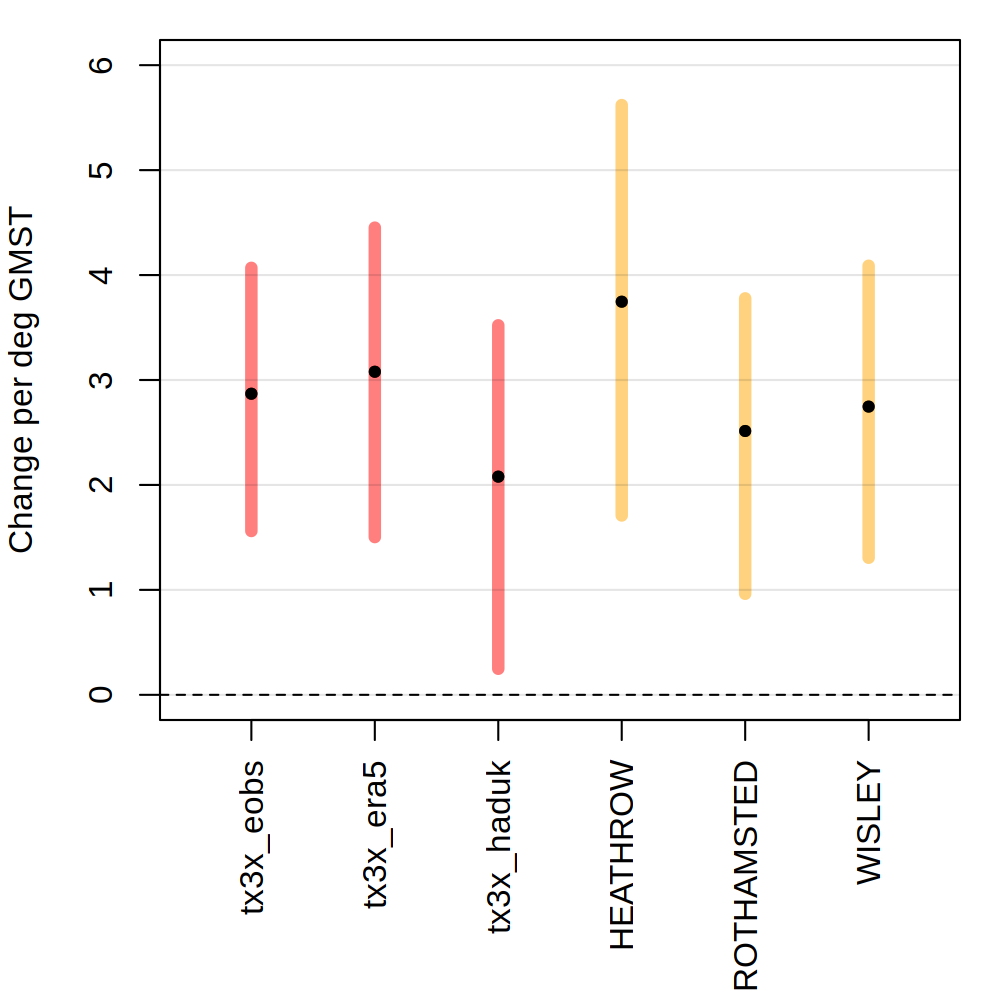

In [126]:
prep_window(c(1,1), mar = c(7,4,1,1), h = 5, w = 5)
plot(1:6, res_tx3x[,1], xlim = c(0.5,6.5), ylim = range(pretty(unlist(res_tx3x))), xaxt = "n", xlab = "", ylab = "Change per deg GMST")
segments(x0 = c(1:6), y0 = res_tx3x[,2], y1 = res_tx3x[,3], lwd = 6, col = adjustcolor(c(rep("red", 3), rep("orange", 3)), alpha = 0.5))
points(1:6, res_tx3x[,1])
abline(h = 0:6, col = adjustcolor("black", 0.1))
abline(h = 0, col = "black", lty = 2)
axis(1, at = 1:6, labels = rownames(res_tx3x), las = 2)

In [96]:
res_tx3x

,alpha.gmst_est,alpha.gmst_lower,alpha.gmst_upper
,<dbl>,<dbl>,<dbl>
tx3x_eobs,2.869177,1.5612579,4.068543
tx3x_era5,3.078710,1.5033709,4.451603
tx3x_haduk,2.079029,0.2484639,3.520800
HEATHROW,3.746136,1.7090863,5.619782
ROTHAMSTED,2.514040,0.9630404,3.777651
WISLEY,2.746466,1.3063057,4.088631


# Gridded trend

In [15]:
# loop over all flattened data & fit nonstationary model to each - NB no bootstrapping
fl = list.files(pattern = "flattened", full.names = T)
cov_cf <- data.frame(gmst = c("pi" = -1.3, "2000" = -0.66))

for(fnm in fl) {
    
    res_fnm <- gsub("flattened", "flattened-res", fnm)
    
    if (!file.exists(res_fnm)) {
        
        # load the .csv and 
        df <- read.csv(fnm, skip = 3, header = F)
        colnames(df)[1] <- "year"
        df <- merge(gmst, df)

        # fit nonstationary model to all columns
        models <- sapply(colnames(df)[grepl("V", colnames(df))], function(cnm) {
            df_c <- df[,c("year", "gmst", cnm)]
            tryCatch({
                fit_ns("gev", "shift", df_c, cnm, c("gmst"), lower = F)
            }, error = function(cond) { return(NULL) })
        }, simplify = F)

        # get all model results & save as .csv to be reconstructed & plotted in python
        fitted_res <- sapply(models, function(mdl) {
            if(!is.null(unlist(mdl)[1])) {
                mdl_ests(mdl, cov_f = cov_2025, cov_cf = cov_cf, rp = 5)
            } else {
                rep(NA, 14)
            }})
        write.csv(fitted_res, res_fnm)
    }
}